## Variational AutoEncoder (VAE) - MNIST data
From [Keras-Team, author-fchollet (github)](https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py) or step-by-step explanation on [Keras documentation-examples](https://keras.io/examples/generative/vae/).

In [16]:
import re, os, random

# Add paths to custom modules
for custom_files in ['customclasses','custom-classes-vae']:
    datadir = os.path.join('/kaggle/input', custom_files)
    if datadir not in os.sys.path:
        os.sys.path.insert(0, datadir)


# Import all custom variables and modules
from mnist import *
from vae import *

TRAIN_MODEL = True
RND_STATE = 247
ARCH_NN = 'autoencoder' # 'vae', 'gan'
tf.keras.utils.set_random_seed(RND_STATE)

### 1. Build the encoder 

In [17]:
img_dim = 28
latent_dim = 32
encoder = get_encoder(latent_dim=latent_dim, input_dim=img_dim, ARCH_NN=ARCH_NN)
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 32)           320       ['input_3[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_2[0][0]']            
                                                                                                  
 flatten_1 (Flatten)         (None, 3136)                 0         ['conv2d_3[0][0]']            
                                                                                            

### 2. Build the decoder

In [18]:
decoder = get_decoder(latent_dim)
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_3 (Dense)             (None, 3136)              103488    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 28, 28, 1)         289 

### 3. Import training data

In [19]:
# Load Hand-written alphabet images
if 'letters' not in dir():
    letters = MNIST_letters(
        '/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv'
    )
    
# Preprocessing and normalization
(x_train, y_train), (x_test, y_test) = letters.split_data(train_ratio=0.1,\
                                                          random_state=RND_STATE)
mnist_letters = letters.normalize(x_train)
print("Shape of MNIST dataset: {}\nShape of training data: {}"
      .format(str(letters.df.shape),str(mnist_letters.shape)))

Shape of MNIST dataset: (144013, 784)
Shape of training data: (14401, 28, 28, 1)


### 4. Train the VAE

In [20]:
callback = keras.callbacks.EarlyStopping(
    monitor="reconstruction_loss", 
    patience=3, 
    verbose=1, 
    restore_best_weights=True
)

model = VAE(encoder, decoder)
model.compile(optimizer=keras.optimizers.Adam())
if TRAIN_MODEL:
    model.fit(mnist_letters, epochs=30, batch_size=128, callbacks=[callback])
    # model.save('model.keras')
    model.save_weights('/kaggle/working/checkpoints/last_checkpoint')
else:
    # model = keras.models.load_model('model.keras')
    model.load_weights('/kaggle/working/checkpoints/last_checkpoint')
    

Epoch 1/30
113/113 [==============================] - 12s 88ms/step - loss: 323.1147 - reconstruction_loss: 247.1265 - kl_loss: 0.0000e+00
Epoch 2/30
113/113 [==============================] - 10s 92ms/step - loss: 182.8094 - reconstruction_loss: 167.5565 - kl_loss: 0.0000e+00
Epoch 3/30
113/113 [==============================] - 10s 89ms/step - loss: 128.3507 - reconstruction_loss: 122.2039 - kl_loss: 0.0000e+00
Epoch 4/30
113/113 [==============================] - 10s 88ms/step - loss: 109.3826 - reconstruction_loss: 106.8842 - kl_loss: 0.0000e+00
Epoch 5/30
113/113 [==============================] - 10s 92ms/step - loss: 100.2341 - reconstruction_loss: 98.4444 - kl_loss: 0.0000e+00
Epoch 6/30
113/113 [==============================] - 10s 88ms/step - loss: 93.6651 - reconstruction_loss: 92.5343 - kl_loss: 0.0000e+00
Epoch 7/30
113/113 [==============================] - 10s 88ms/step - loss: 89.5821 - reconstruction_loss: 88.9557 - kl_loss: 0.0000e+00
Epoch 8/30
113/113 [============

## VAE predictions

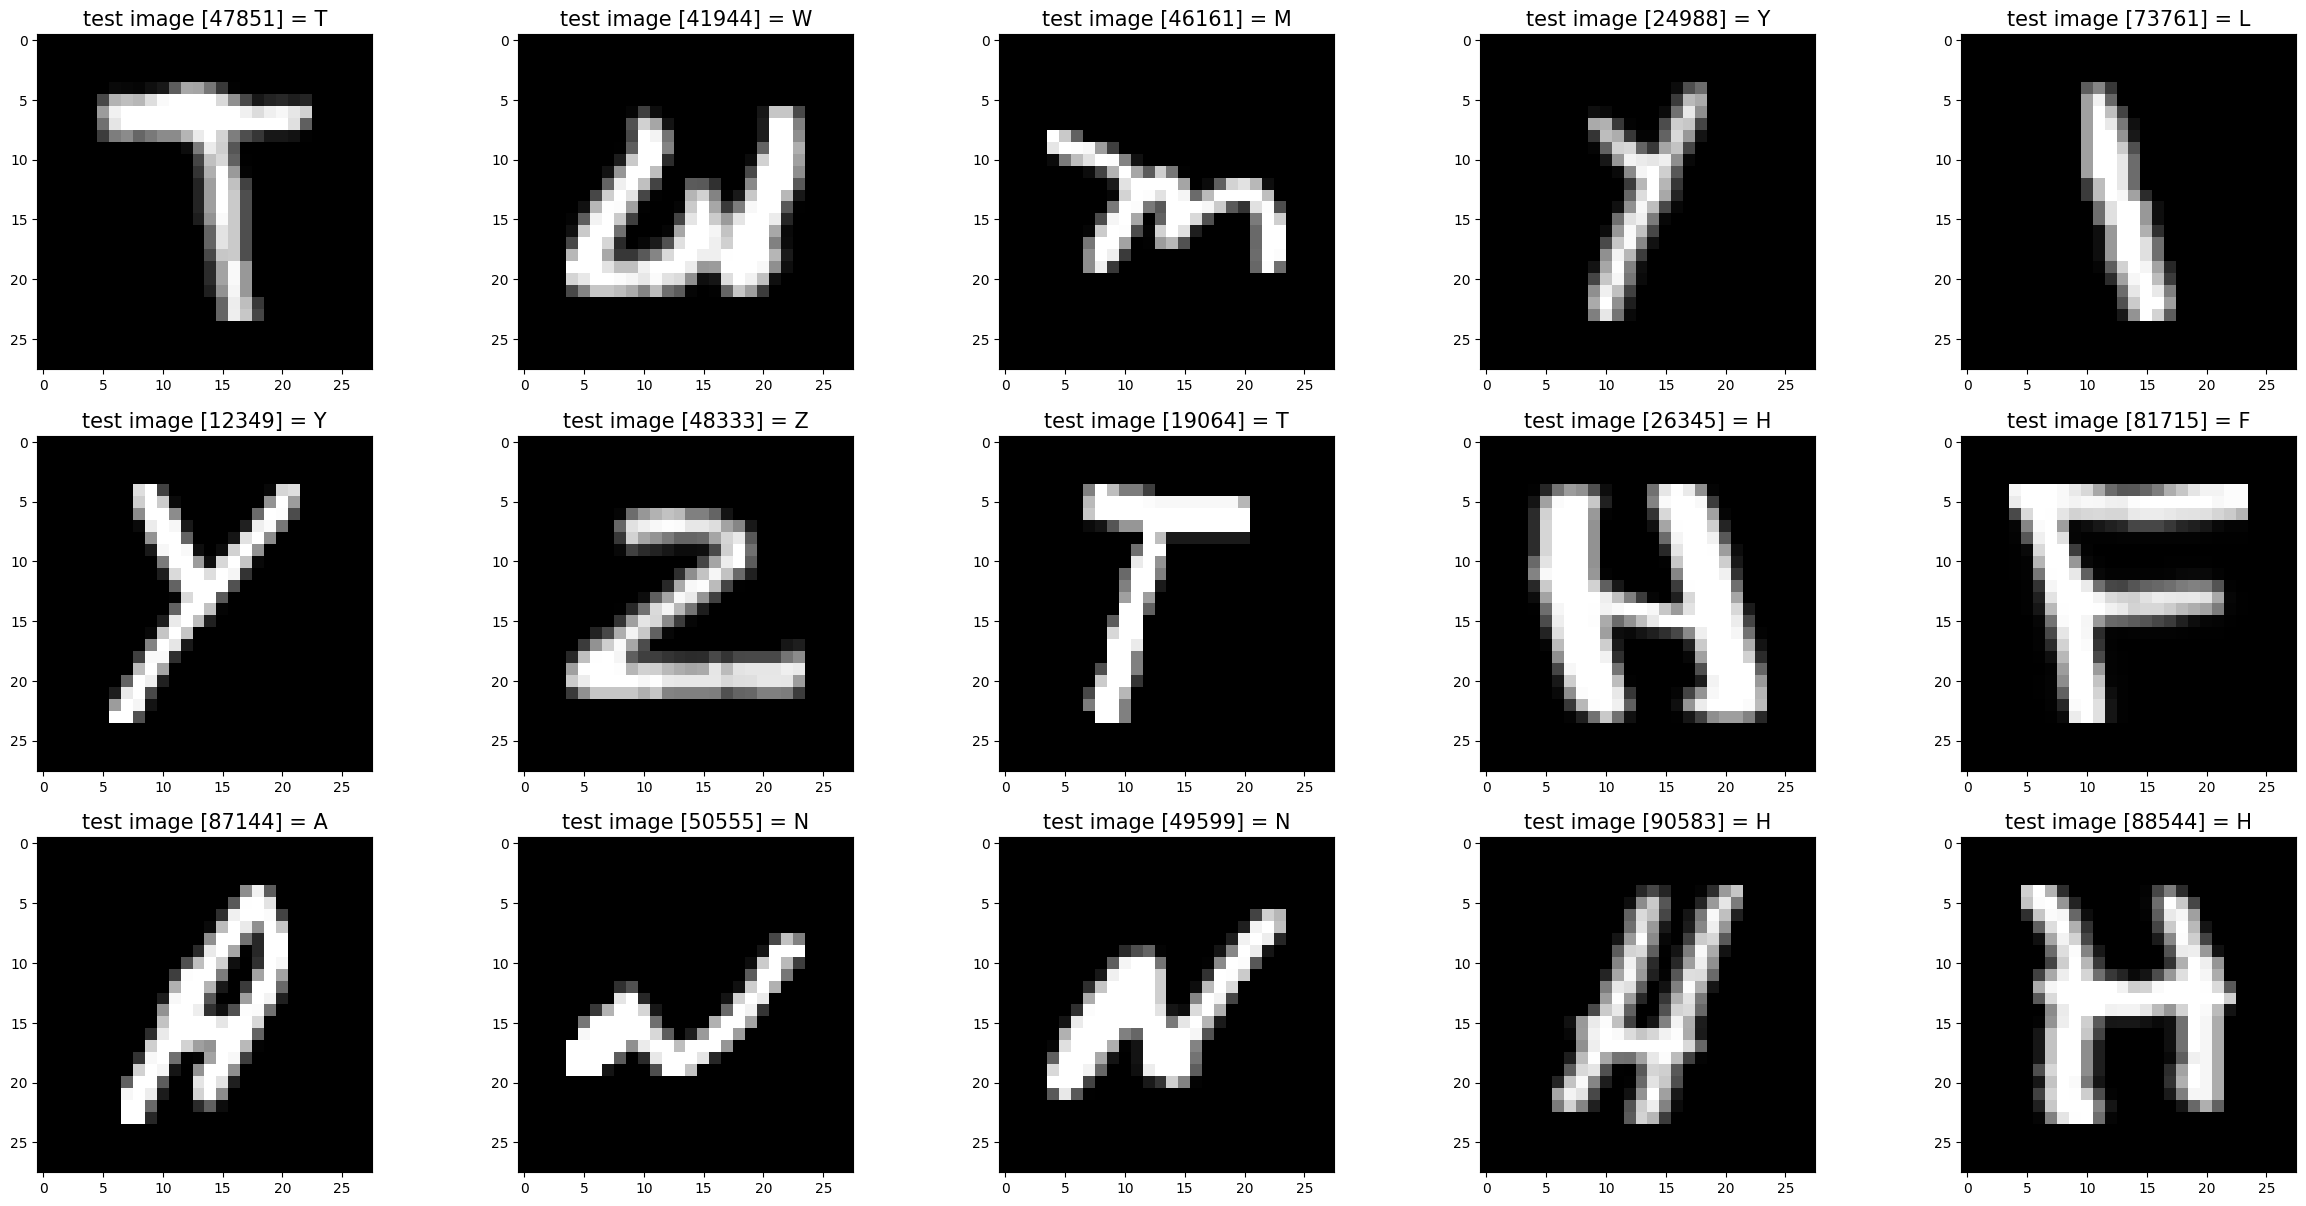

In [21]:
# Show some random test images 
#
images_2_show = []
titles_2_show = []
test_sample = np.random.choice(range(len(y_test)), size=15)
for r in test_sample:
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + letters.labels[y_test[r]])    

show_images(images_2_show, titles_2_show)

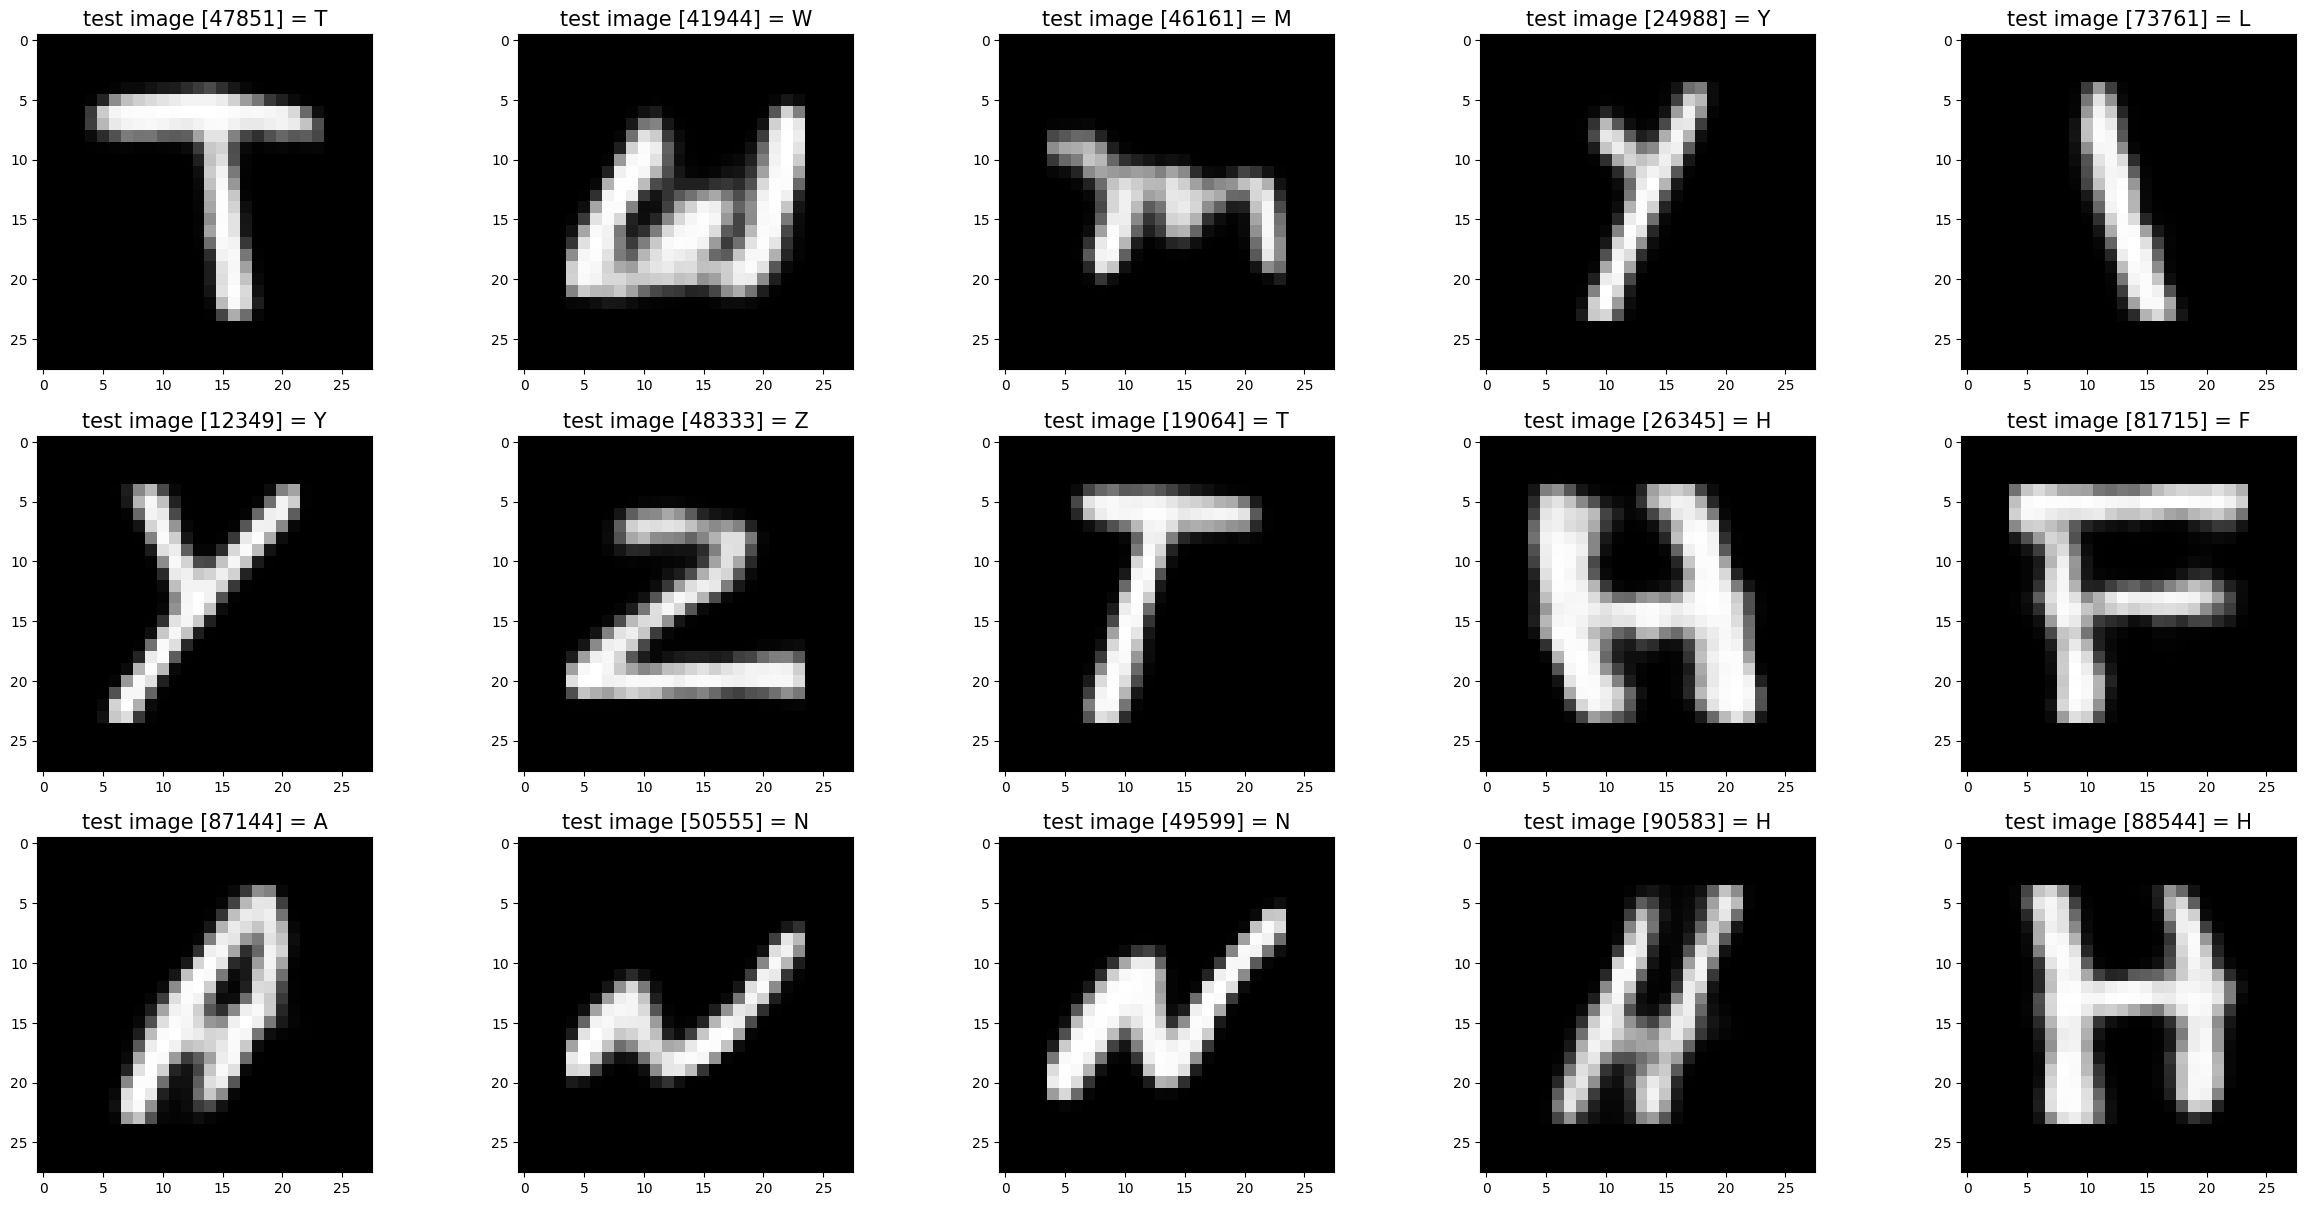

In [22]:
# Use trained VAE to predict samples selected above 
#
images_2_show = []
titles_2_show = []  

x_decoded, _ = model.predict(letters.normalize(x_test[test_sample]), verbose=0)
x_decoded = letters.inverse_transform(x_decoded)
for i, r in enumerate(test_sample):
    images_2_show.append(x_decoded[i].reshape(img_dim,img_dim))       
    titles_2_show.append('test image [' + str(r) + '] = ' + letters.labels[y_test[r]])    

show_images(images_2_show, titles_2_show)

In [23]:
# Load MNIST digit dataset
#
input_path = '../input/mnist-dataset'
input_path = [
    os.path.join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte'),
    os.path.join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte'),
    os.path.join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte'),
    os.path.join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')
]

digits = MNIST_digits(*input_path)
(x_train_, y_train_), (x_test_, y_test_) = digits.load_data()

select1 = (y_train_==1) | (y_train_==7) | (y_train_==4)
select2 = (y_test_==1) | (y_test_==7) | (y_test_==4)
x_train_, y_train_ = x_train_[select1], y_train_[select1]
x_test_, y_test_ = x_test_[select2], y_test_[select2]
mnist_digits = np.concatenate([x_train_, x_test_], axis=0)
mnist_labels = np.concatenate([y_train_, y_test_])

print("Dimension of mnist_digits: {:<15}".format(str(mnist_digits.shape)))
print("Dimension of mnist_labels: {:<15}".format(str(mnist_labels.shape)))

Dimension of mnist_digits: (21994, 28, 28)
Dimension of mnist_labels: (21994,)       


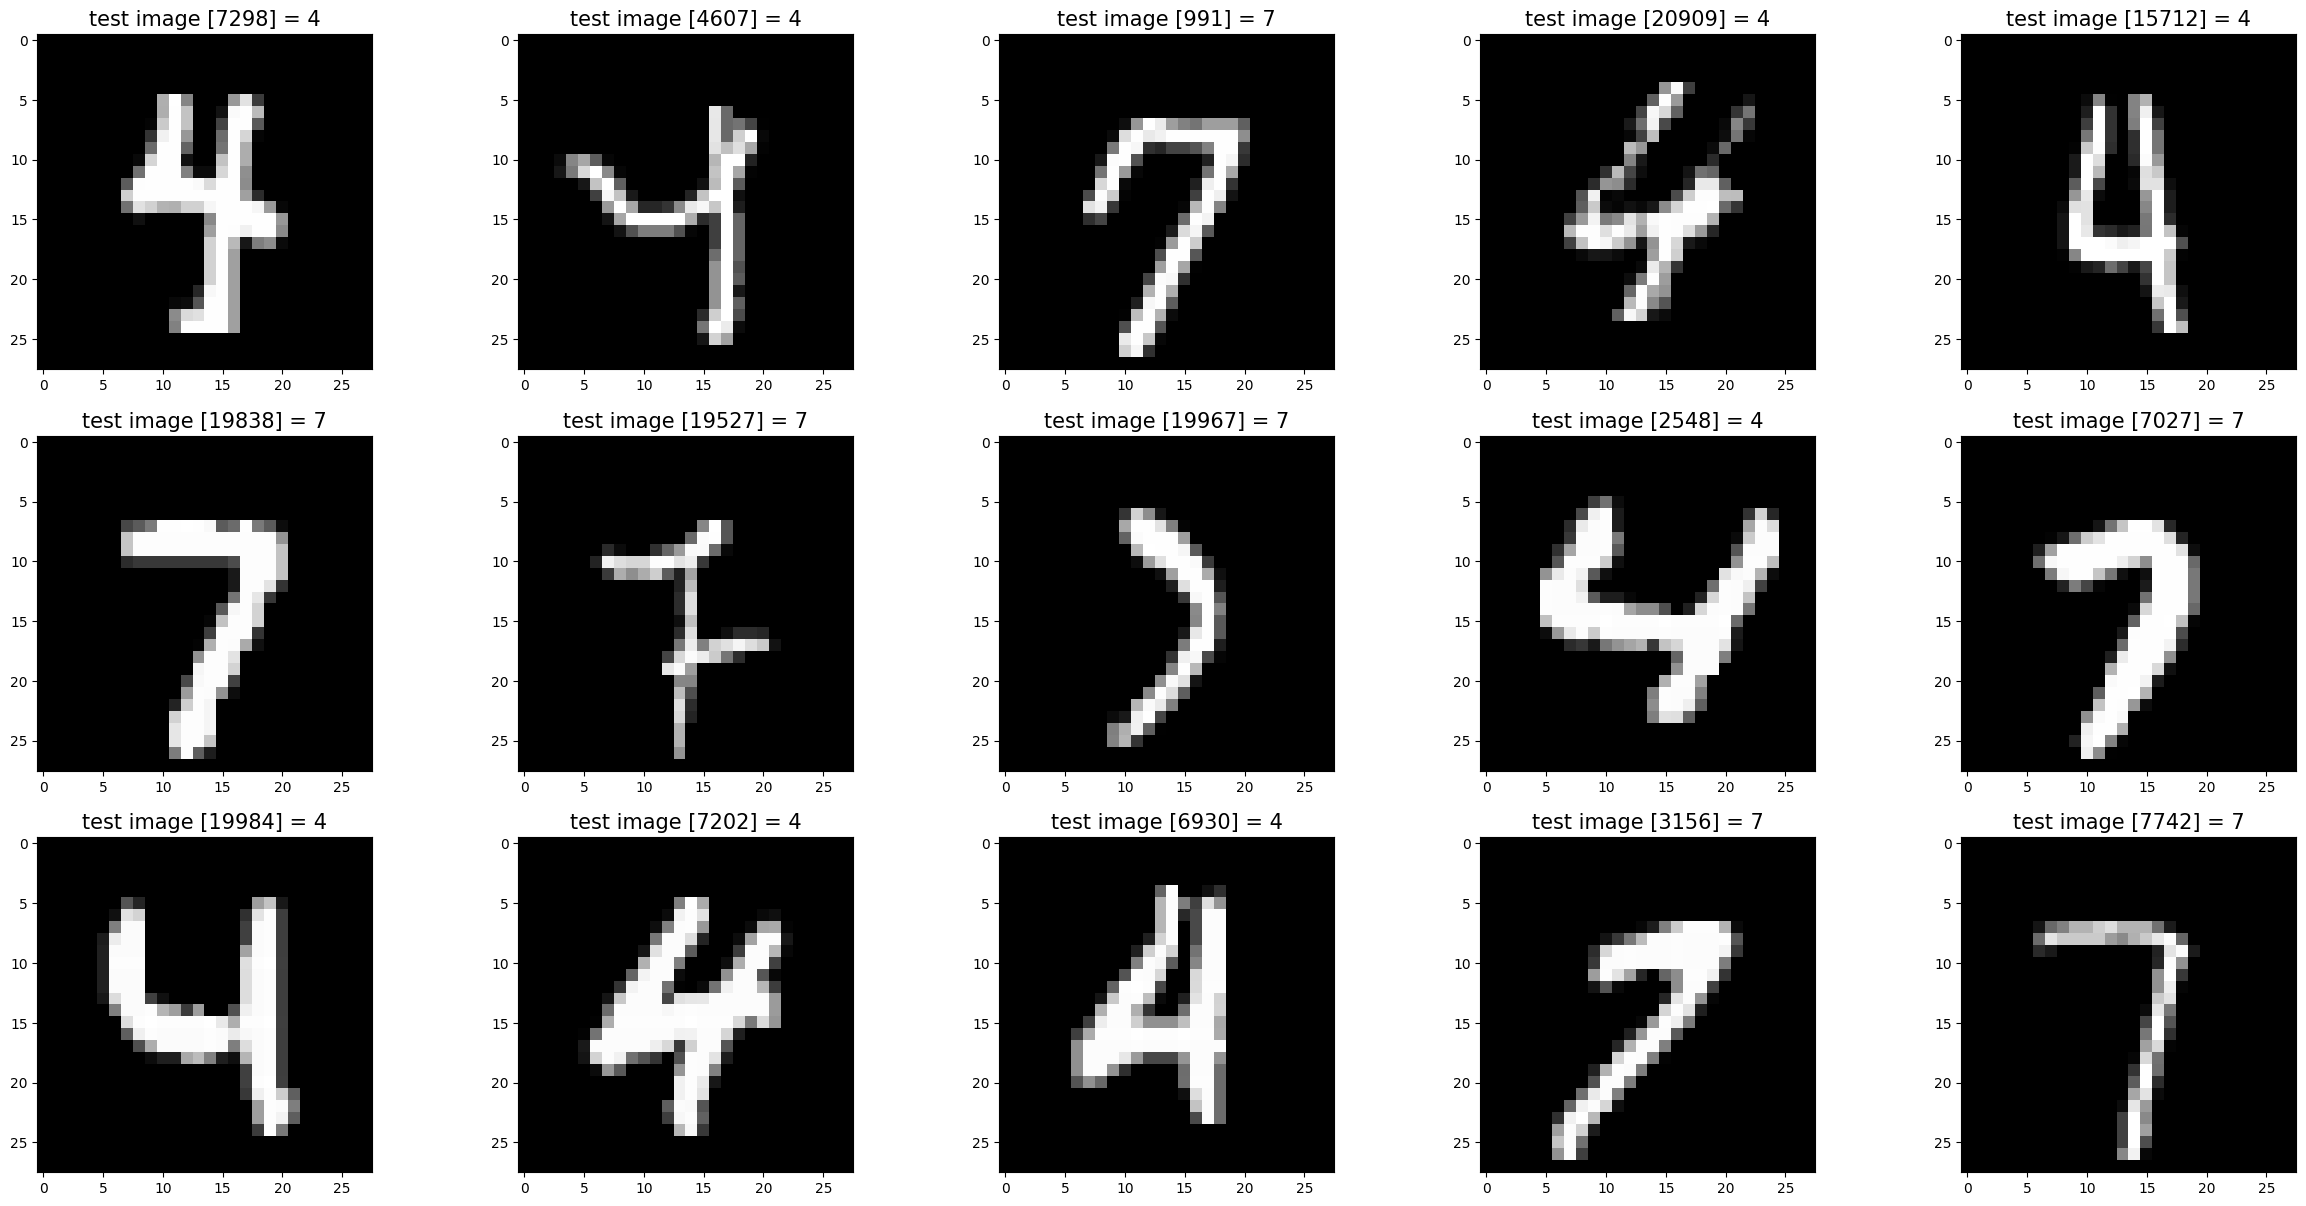

In [24]:
# Show some random test images 
#
images_2_show = []
titles_2_show = []
test_sample2 = np.random.choice(range(len(mnist_labels)), size=15)
for r in test_sample2:
    images_2_show.append(mnist_digits[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(mnist_labels[r]))    

show_images(images_2_show, titles_2_show)

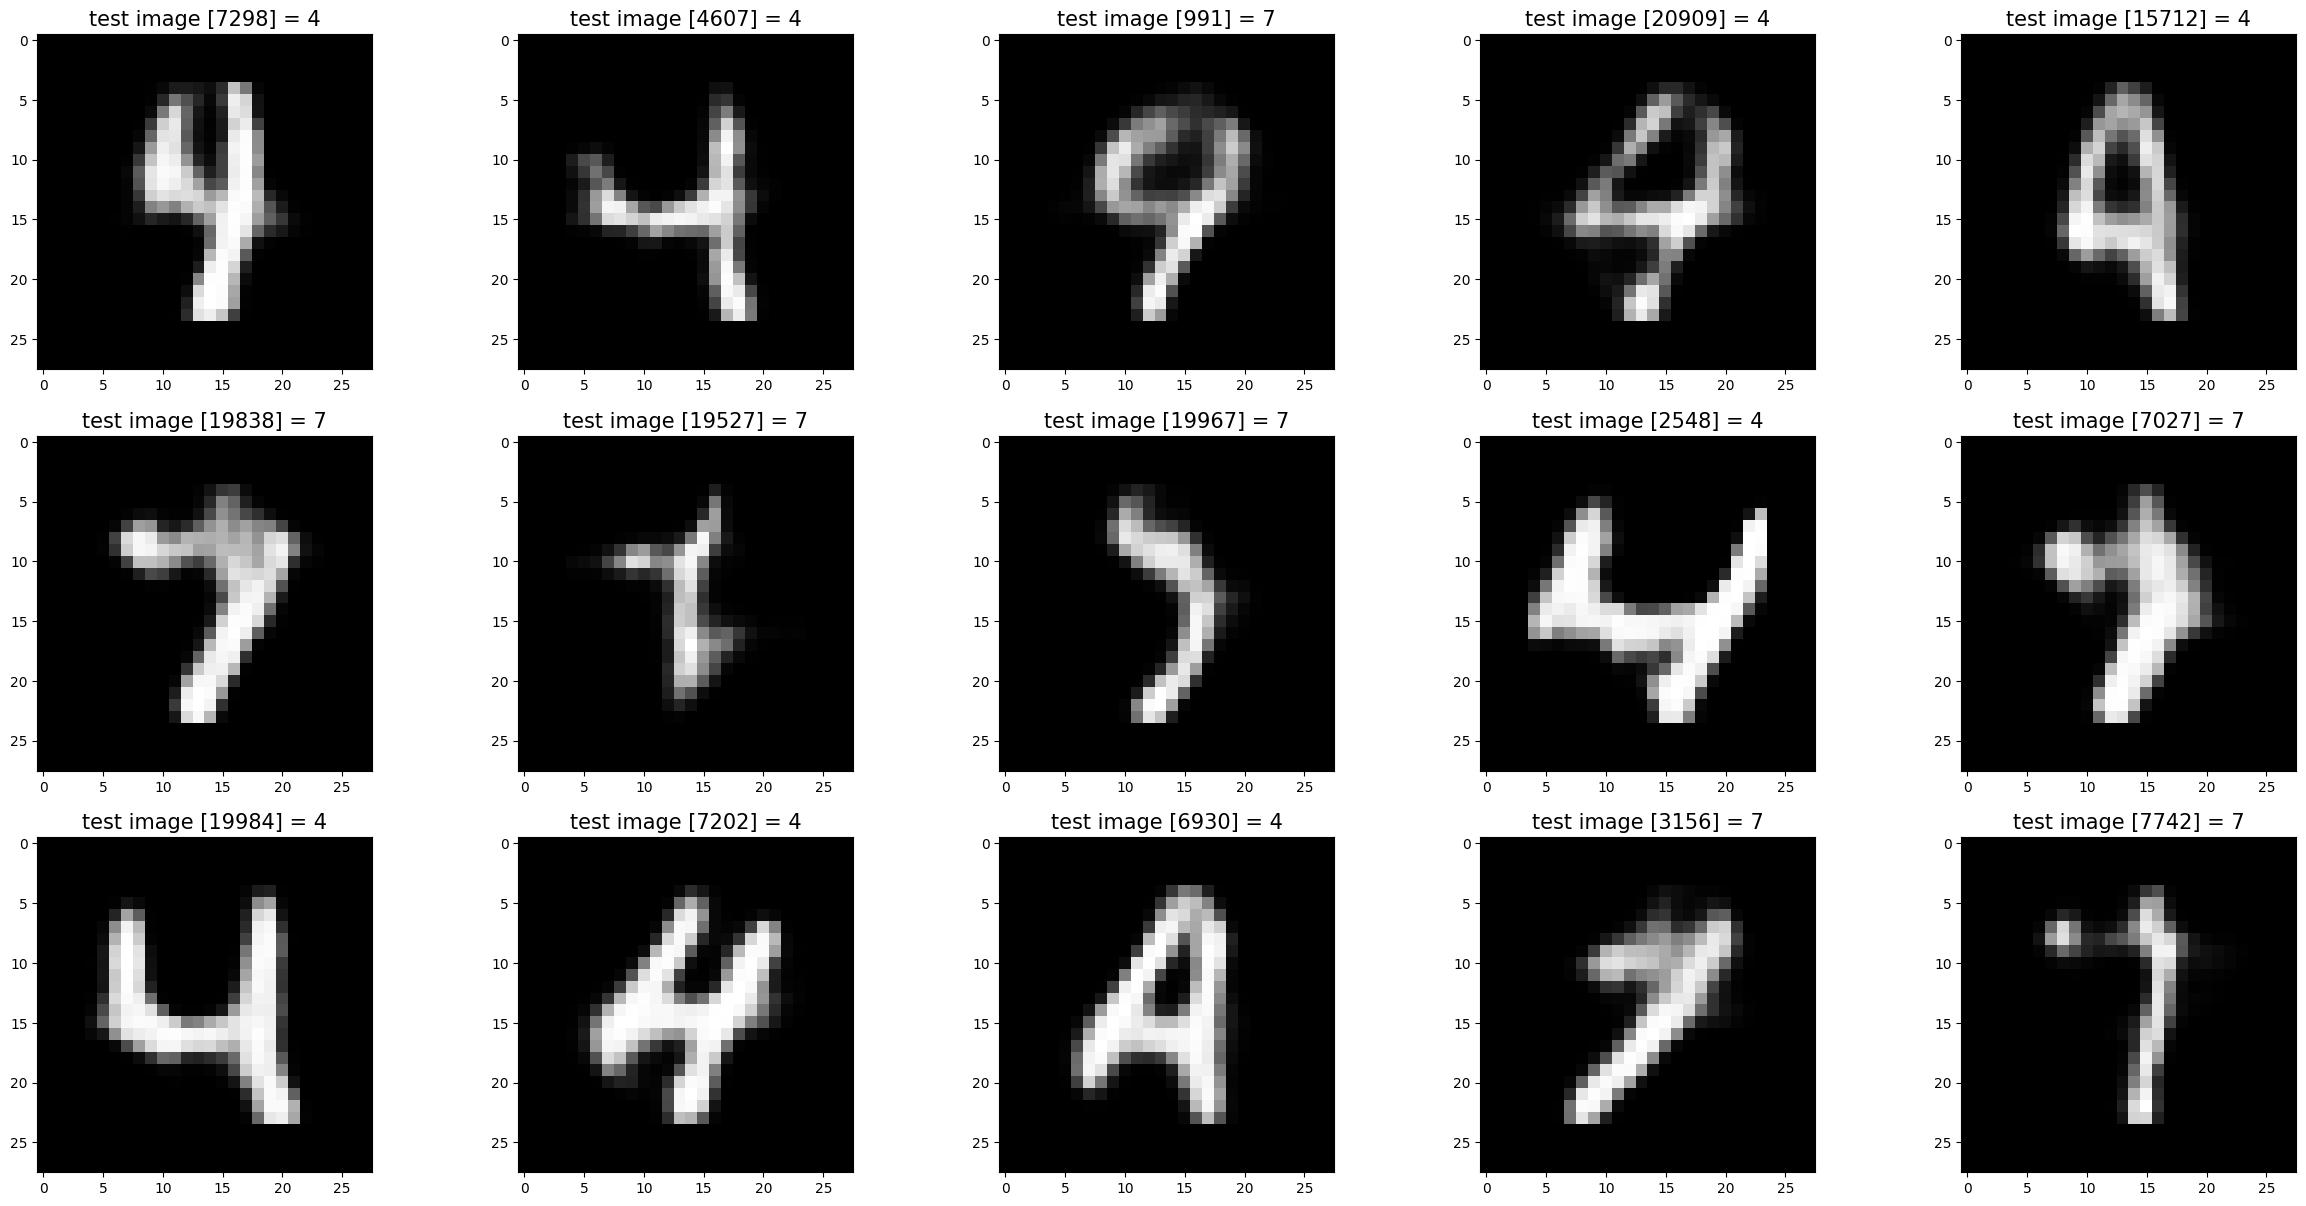

In [25]:
# Use trained VAE to predict samples selected above 
#
images_2_show = []
titles_2_show = []

x_decoded, _ = model.predict(letters.normalize(mnist_digits[test_sample2]), verbose=0)
x_decoded = letters.inverse_transform(x_decoded)
img_shape = x_decoded[0].shape[:2]
for i, r in enumerate(test_sample2):
    images_2_show.append(x_decoded[i].reshape(img_shape))
    titles_2_show.append('test image [' + str(r) + '] = ' + str(mnist_labels[r]))  

show_images(images_2_show, titles_2_show)

### Display a grid of sampled digits

In [26]:
# plot_latent_space(model)

### Display how the latent space clusters different digit classes

In [27]:
# plot_label_clusters(model, x_train[select1], y_train[select1])